In [1]:
from sandbox.multiplex_network import MultiplexNetwork, GowerSimilarity
import pandas as pd

In [2]:
df = pd.read_csv("..\output\\results.csv")
df = df.iloc[df["BibliotecaNombre"].drop_duplicates(keep="first").index]
df.drop(labels=["tieneComputador", "tieneConectividad"], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,BibliotecaID,BibliotecaNombre,infraestructura_tecnologica,catalogo_digitalización,porcentaje_coleccion_catalogada,nivel_detalle_catalogo,sistemas_clasificacion,nivel_detalle_organizacion_coleccion,tiempo_busqueda_libro,sistema_registro_usuarios,reglamento_servicios,sistematización_prestamo_externo,tipos_coleccion,cantidad_inventario,percepcion_estado_colecciones,enfoques_colecciones,actividades_mediacion,frecuencia_actividades_mediacion,colecciones_especiales
0,BCPA001,Biblioteca Comunitaria Casa Viva,2,3,7.4,2,1,3,3,3,1,4,"['literatura', 'infantiles', 'informativos']",0.0,2,"['infantil', 'primera_infancia', 'digital', 'm...","['clubes_de_lectura_temáticos', 'talleres_de_e...",3,"['creaciones_locales', 'memoria_local', 'memor..."
1,BCSB005,Biblioteca Comunitaria La BibloCleta,0,2,50.0,3,0,0,2,0,0,0,"['literatura', 'infantiles', 'texto', 'didacti...",0.0,3,"['derechos_humanos', 'pedagogía', 'literatura'...",['biblioteca_al_parque'],3,"['sí', 'creaciones_locales']"
2,BCSB009,Biblioteca Comunitaria La Montaña Mágica,2,0,0.0,0,1,3,3,0,1,1,"['literatura', 'infantiles', 'informativos', '...",2.0,1,['literatura'],"['clubes_de_lectura_temáticos', 'talleres_de_e...",2,"['sí', 'creaciones_locales']"
3,BCBS006,Biblioteca Comunitaria Taller Comunitario Luci...,1,0,0.0,0,1,3,3,0,1,0,"['literatura', 'infantiles', 'informativos', '...",2.0,2,"['literatura', 'infantil', 'política', 'educac...",['por_el_momento_la_biblioteca_esta_en_organiz...,3,"['creaciones_locales', 'ademas_se_cuenta_con_u..."
4,BCKD007,Biblioteca Comunitaria de Imágenes,0,0,0.0,0,0,0,2,0,1,0,NaN,NaN,3,"['arte', 'artes_visuales', 'fanzines_propios_c...","['conversatorios_con_autores_locales', 'activi...",3,['si_publicaciones_de_los_años_70_y_ediciones_...
5,BCRU001,Biblioteca Comunitaria Manuela Beltrán,0,2,100.0,1,1,4,1,1,2,1,NaN,NaN,2,"['ciencia', 'sociología']","['talleres_de_escritura', 'círculos_de_lectura...",2,"['sí', 'creaciones_locales', 'si', 'recuperaci..."
6,BCRU003,Biblioteca Comunitaria Raíz de Barro,0,2,50.0,3,2,3,3,0,2,2,NaN,NaN,2,"['genero', 'literatura', 'infantil', 'educació...","['círculos_de_lectura', 'actividades_de_lectur...",3,"['sí', 'creaciones_locales', 'si', 'recuperaci..."
7,BCKD010,Biblioteca Comunitaria CENTRO CULTURAL SIKUWAYRA,2,2,40.0,2,1,2,3,2,3,3,"['literatura', 'infantiles', 'informativos', '...",1.0,2,"['pedagogía', 'literatura', 'infantil', 'educa...","['clubes_de_lectura_temáticos', 'talleres_de_e...",3,"['sí', 'creaciones_locales', 'sí', 'recuperaci..."
8,BCUS001,Biblioteca Comunitaria Babilonia,2,2,50.0,3,1,2,1,1,1,2,"['literatura', 'infantiles', 'informativos', '...",3.0,2,"['creación_propia', 'literatura', 'infantil', ...","['talleres_de_escritura', 'conversatorios_con_...",3,"['sí', 'recuperación_de_la_memoria', 'libro_de..."
9,BCKD016,Biblioteca Comunitaria Ojos Café (Itinerante),0,2,70.0,1,0,1,2,0,0,1,"['literatura', 'infantiles', 'informativos', '...",0.0,2,"['pedagogía', 'arte']","['clubes_de_lectura_temáticos', 'círculos_de_l...",0,['no']


# Algunas consideraciones para los datos faltantes.




In [3]:
df.isna().any()

BibliotecaID                            False
BibliotecaNombre                        False
infraestructura_tecnologica             False
catalogo_digitalización                 False
porcentaje_coleccion_catalogada         False
nivel_detalle_catalogo                  False
sistemas_clasificacion                  False
nivel_detalle_organizacion_coleccion    False
tiempo_busqueda_libro                   False
sistema_registro_usuarios               False
reglamento_servicios                    False
sistematización_prestamo_externo        False
tipos_coleccion                          True
cantidad_inventario                      True
percepcion_estado_colecciones           False
enfoques_colecciones                    False
actividades_mediacion                   False
frecuencia_actividades_mediacion        False
colecciones_especiales                  False
dtype: bool

In [4]:
# find index with missing values
index = df[df.isna().any(axis=1)].index
df.iloc[index]

,BibliotecaID,BibliotecaNombre,infraestructura_tecnologica,catalogo_digitalización,porcentaje_coleccion_catalogada,nivel_detalle_catalogo,sistemas_clasificacion,nivel_detalle_organizacion_coleccion,tiempo_busqueda_libro,sistema_registro_usuarios,reglamento_servicios,sistematización_prestamo_externo,tipos_coleccion,cantidad_inventario,percepcion_estado_colecciones,enfoques_colecciones,actividades_mediacion,frecuencia_actividades_mediacion,colecciones_especiales
4,BCKD007,Biblioteca Comunitaria de Imágenes,0,0,0.0,0,0,0,2,0,1,0,NaN,NaN,3,"['arte', 'artes_visuales', 'fanzines_propios_c...","['conversatorios_con_autores_locales', 'activi...",3,['si_publicaciones_de_los_años_70_y_ediciones_...
5,BCRU001,Biblioteca Comunitaria Manuela Beltrán,0,2,100.0,1,1,4,1,1,2,1,NaN,NaN,2,"['ciencia', 'sociología']","['talleres_de_escritura', 'círculos_de_lectura...",2,"['sí', 'creaciones_locales', 'si', 'recuperaci..."
6,BCRU003,Biblioteca Comunitaria Raíz de Barro,0,2,50.0,3,2,3,3,0,2,2,NaN,NaN,2,"['genero', 'literatura', 'infantil', 'educació...","['círculos_de_lectura', 'actividades_de_lectur...",3,"['sí', 'creaciones_locales', 'si', 'recuperaci..."
11,BCSC002,Biblioteca Comunitaria ALTAMIRA PEPASO,2,2,70.0,3,1,4,2,0,1,0,"['literatura', 'infantiles', 'texto', 'didacti...",NaN,2,"['literatura', 'ciencia', 'infantil']","['talleres_de_escritura', 'círculos_de_lectura...",2,"['sí', 'recuperación_de_la_memoria', 'libros_d..."
12,BCBS001,Biblioteca Comunitaria Casa de las luciérnagas,2,0,0.0,0,0,2,1,2,2,2,"['literatura', 'infantiles', 'informativos', '...",NaN,2,"['creación_propia', 'infantil', 'educación_amb...","['talleres_de_escritura', 'actividades_de_lect...",3,"['sí', 'creaciones_locales', 'sí', 'recuperaci..."


Hay tres bibliotecas que no tienen datos de SiBiBo.

- BCKD007	Biblioteca Comunitaria de Imágenes
- BCRU001	Biblioteca Comunitaria Manuela Beltrán
- BCRU003	Biblioteca Comunitaria Raíz de Barro

Por lo que es necesario colocar manualmente el valor de _infraestructura_tecnologica_ y cantidad inventario, este ultimo valor fue preguntado durante las visitas de campo y le hacia falta a las siguiente bibliotecas también.

- BCSC002   Biblioteca Comunitaria ALTAMIRA PEPASO
- BCBS001   Biblioteca Comunitaria Casa de las luciérnagas


Para tipo_colección lo dejaremos como nulo, ya que no se tiene información de este campo.

In [5]:
def update_column_with_dict(df, column_to_update, key_column, corrections_dict):
    """
    Actualiza los valores de una columna específica en un DataFrame usando un diccionario.

    Args:
    df (pd.DataFrame): DataFrame a modificar.
    column_to_update (str): Nombre de la columna donde se aplicarán las correcciones.
    key_column (str): Nombre de la columna con las claves para el diccionario.
    corrections_dict (dict): Diccionario con claves y valores para actualizar.

    Returns:
    pd.DataFrame: DataFrame actualizado.
    """
    # Aplicar las correcciones
    df[column_to_update] = df.apply(
        lambda row: corrections_dict[row[key_column]]
        if row[key_column] in corrections_dict else row[column_to_update],
        axis=1
    )
    return df

In [6]:
correccion_infra = {
"BCKD007": 2,
"BCRU001": 2,
"BCRU003": 2,
}
df = update_column_with_dict(df, "infraestructura_tecnologica", "BibliotecaID", correccion_infra)

correccion_total_inventario = {
"BCKD007": 0,
"BCRU001": 2,
"BCRU003": 3,
"BCSC002": 3,
"BCBS001": 1,

}
df = update_column_with_dict(df, "cantidad_inventario", "BibliotecaID", correccion_total_inventario)


C:\Users\luise\Documents\Proyectos\Bibliotecas\bibliotecas_comunitarias_grafos\sandbox\multiplex_network.py:68: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[multi_label_cols] = df[multi_label_cols].applymap(lambda x: x if isinstance(x, list) else [])


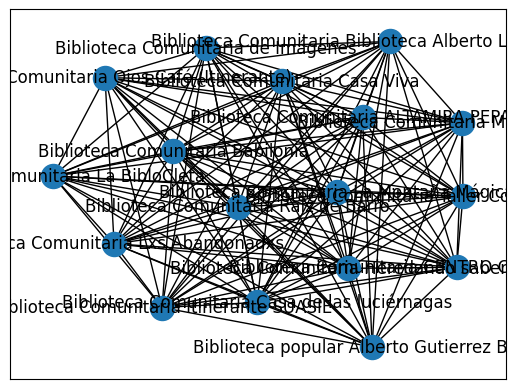

In [7]:
from sandbox.multiplex_network import LayerFactory

# Create layer factory with Gower similarity
factory = LayerFactory(
    similarity_strategy=GowerSimilarity
)

# Create network layer with optimization
network = factory.create_layer(
    master_table=df,
    nodes_name=list(df["BibliotecaNombre"].unique()),
    weighting_strategy='feature_entropy',
    threshold=None,
    nan_strategy='impute'
)
import networkx as nx
nx.draw_networkx(network, with_labels=True)

In [8]:
nx.write_graphml(network, "network.graphml")